In [1]:
%matplotlib notebook
import os
import h5py
import tensorflow as tf
from tensorflow import keras
from Jinvariant_autoencoder_larger_inputs.py import UNet, CallBacks, DataGenerator
import matplotlib.pyplot as plt
from csbdeep.utils import plot_history
import obspy
import shutil
import numpy as np
import numpy.ma as ma
""" Setting random seeds """
from models import seed

# TensorFlow
tf.random.set_seed(seed)

# Python
import random as python_random
python_random.seed(seed)

# NumPy (random number generator used for sampling operations)
rng = np.random.default_rng(seed)

In [2]:
""" Definitions/parameters """

N_sub = 11
batch_size = 32

model_name = "model_snr_1_big_model"
model_params = {
    "use_bn": True,
    "use_dropout": True,
    "dropout_rate": 0.1,
    "N_blocks": 4,
    "f0": 4,
    "LR": 1e-4,
    "data_shape": (N_sub, 2048, 1),
    "kernel": (3, 5),
    "AA": True,
}

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
data_file = os.path.join(data_dir, "SCSN", "waveforms.npy")

""" Callbacks """

logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)
    
savefile = "model_snr_1_big_model.h5"
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

tensorboard_callback = CallBacks.tensorboard(logdir)
checkpoint_callback = CallBacks.checkpoint(os.path.join(savedir, savefile))

In [3]:
with open('list_noisy_arrays.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
listing = [str(item) for item in list_of_strings if item]

In [4]:
print("Preparing masks")
# Prepare data generators
train_generator = DataGenerator(listing[39:253], N_sub=N_sub, batch_size=batch_size, batch_multiplier=5)
test_generator = DataGenerator(listing[253:273], N_sub=N_sub, batch_size=batch_size, batch_multiplier=5)

print("Done")

Preparing masks
Done


<IPython.core.display.Javascript object>


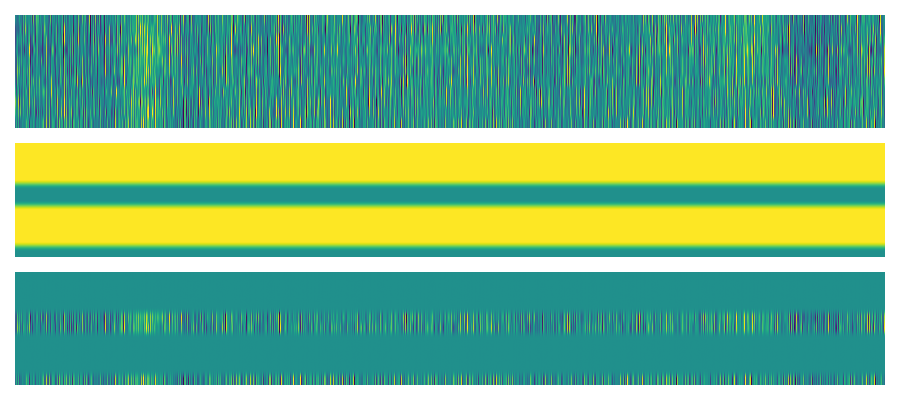

In [5]:
# Select one mini-batch sample for inspection
(samples, masks), masked_samples = test_generator.__getitem__(3)

# Draw canvas
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))

axes[0].imshow(samples[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[0].axis("off")

axes[1].imshow(masks[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[1].axis("off")

axes[2].imshow(masked_samples[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [6]:
# show the model trained on synthetic data
net = UNet()
net.set_params(model_params)
model = net.construct()
model.summary()

C:\Users\MFE\AppData\Roaming\Python\Python38\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11, 2048, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_1 (InputLayer)           [(None, 11, 2048, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 11, 2048, 1)  0           ['input_2[0][0]',                
                                                                  'input_1[0][0]']            

                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 11, 509, 8)  0           ['gaussian_dropout_5[0][0]']     
                                                                                                  
 tf.compat.v1.nn.conv2d_1 (TFOp  (None, 11, 128, 8)  0           ['max_pooling2d_1[0][0]']        
 Lambda)                                                                                          
                                                                                                  
 conv2d_6 (Conv2D)              (None, 11, 128, 16)  1920        ['tf.compat.v1.nn.conv2d_1[0][0]'
                                                                 ]                                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 11, 128, 16)  64         ['conv2d_6[0][0]']               
 rmalizati

                                                                                                  
 conv2d_12 (Conv2D)             (None, 11, 32, 32)   46080       ['concatenate[0][0]']            
                                                                                                  
 batch_normalization_12 (BatchN  (None, 11, 32, 32)  128         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 11, 32, 32)   0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 gaussian_dropout_12 (GaussianD  (None, 11, 32, 32)  0           ['activation_12[0][0]']          
 ropout)                                                                                          
          

 gaussian_dropout_18 (GaussianD  (None, 11, 2048, 8)  0          ['activation_18[0][0]']          
 ropout)                                                                                          
                                                                                                  
 conv2d_19 (Conv2D)             (None, 11, 2048, 16  1920        ['gaussian_dropout_18[0][0]']    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 11, 2048, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_19 (Activation)     (None, 11, 2048, 16  0           ['batch_normalization_19[0][0]'] 
          

In [7]:
# Train model on synthetics
history=model.fit(
    x=train_generator,
    validation_data=test_generator,
    callbacks=[tensorboard_callback, checkpoint_callback],
verbose=1, epochs=50,
)

Epoch 1/50
1070/1070 [==============================] - 9756s 9s/step - loss: 0.1430 - val_loss: 0.1062
Epoch 2/50
1070/1070 [==============================] - 9704s 9s/step - loss: 0.1187 - val_loss: 0.1037
Epoch 3/50
1070/1070 [==============================] - 6564s 6s/step - loss: 0.1143 - val_loss: 0.1037
Epoch 4/50
1070/1070 [==============================] - 5950s 6s/step - loss: 0.1119 - val_loss: 0.0990
Epoch 5/50
1070/1070 [==============================] - 5934s 6s/step - loss: 0.1103 - val_loss: 0.0998
Epoch 6/50
1070/1070 [==============================] - 5942s 6s/step - loss: 0.1093 - val_loss: 0.0994
Epoch 7/50
1070/1070 [==============================] - 5964s 6s/step - loss: 0.1082 - val_loss: 0.0980
Epoch 8/50
1070/1070 [==============================] - 5945s 6s/step - loss: 0.1073 - val_loss: 0.0978
Epoch 9/50
1070/1070 [==============================] - 5861s 5s/step - loss: 0.1066 - val_loss: 0.0964
Epoch 10/50
1070/1070 [==============================] - 7136s 7

['loss', 'val_loss']


<IPython.core.display.Javascript object>


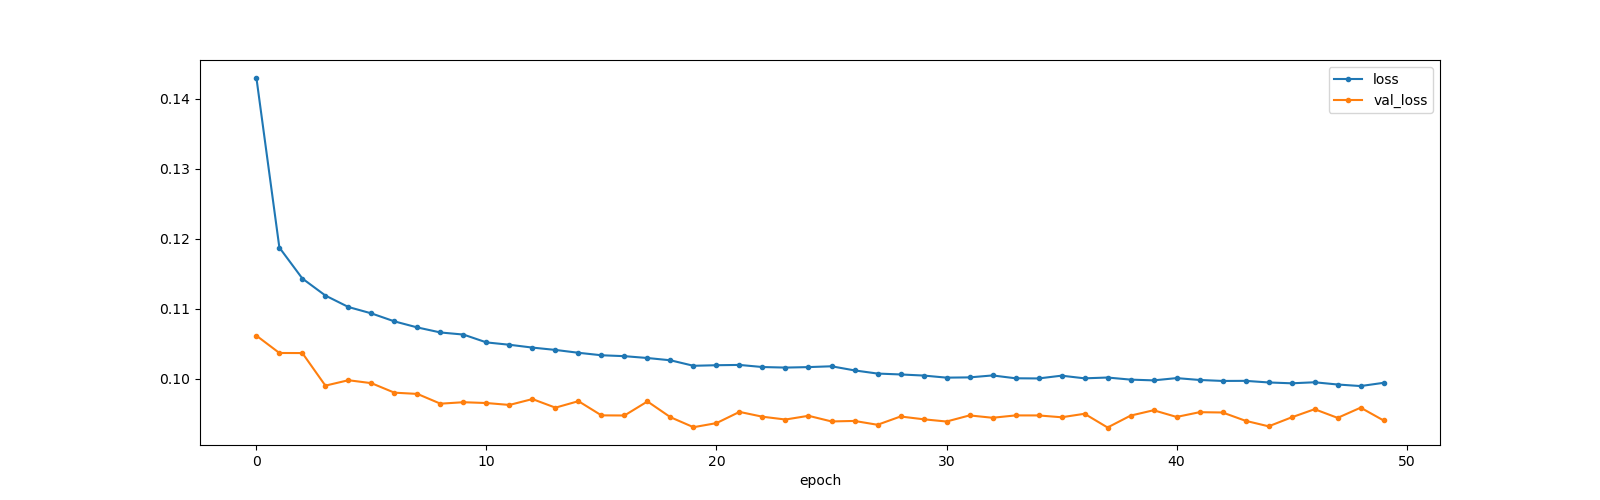

In [9]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);
plt.savefig("figures/model_snr1_big_model.pdf")

In [ ]:
# create an array of size (N_inputs,640,2048)
N_ch, N_t = (640,2048)
data_reconstructions = np.zeros((N_ch,N_t))

data_dir = os.path.join(cwd, "reconstruction_noisy_input_model_snr1_big_training")
# Loop for each input. eval sample each have a shape (640,2048)
for n in range(len(listing[0:273])):
    """ Prepare samples and masks """
    # shape (640,11,2048,1)
    eval_sample = np.load(listing[n])
    masks = np.ones((N_ch, N_sub, N_t, 1))
    eval_samples = np.zeros_like(masks)
    # gutter and mid are both 5
    gutter = N_sub // 2
    mid = N_sub // 2
    for i in range(gutter):
        # 3 masks are put to 0
        masks[i, i:i+3] = 0
        # one channel of eval_samples contains the 11 first channels of eval_sample. shape :(11,2048)
        eval_samples[i, :, :, 0] = eval_sample[:N_sub]
        # i goes from 5 to 634
    for i in range(gutter, N_ch - gutter):
        #goes from 0 to 629
        start = i - mid
        # goes from 11 to 640
        stop = i + mid + 1
        masks[i, mid-1:mid+2] = 0
        #start:stop has a shape of 11 => consistent with first for loop
        eval_samples[i, :, :, 0] = eval_sample[start:stop]

    for i in range(N_ch - gutter, N_ch):
        masks[i, N_sub-3:N_sub] = 0
        eval_samples[i, :, :, 0] = eval_sample[-N_sub:]
    """ Create J-invariant reconstructions """
    results = model.predict((eval_samples, masks))
    for i in range(gutter):
        data_reconstructions[i] = results[i,i,:,0]
    for i in range(gutter, N_ch - gutter):
        data_reconstructions[i] = results[i,mid,:,0]
    for i in range(N_ch - gutter, N_ch):
        data_reconstructions[i] = results[i,N_sub-2,:,0]     
    filename = f"reconstruction_{n}.h5"
    h5file = os.path.join(data_dir, filename)
    with h5py.File(h5file, "w") as h5f:
        h5f.create_dataset("strain_rate", data=data_reconstructions)

In [ ]:
fig = plt.figure(figsize=(9, 6), dpi=150)
plt.plot(eval_sample[40][0:300])
plt.plot(data_reconstructions[40][0:300])

In [ ]:
def generate_noisy_channels(X, s_min=0.1, s_max=1.0, log_SNR_min=-2, log_SNR_max=4):
    """Generate noisy channels for an input of size (n_channels, n_time_samples)
    
    Args:
        X (ndarray): Input array of size (n_channels, n_time_samples)
        s_min (float): Minimum slowness value
        s_max (float): Maximum slowness value
        log_SNR_min (float): Minimum log signal-to-noise ratio (SNR)
        log_SNR_max (float): Maximum log SNR
    
    Returns:
        Noisy version of input array (shape: (n_channels, n_time_samples))
    """
    
    n_channels, n_time_samples = X.shape
    
    rng = np.random.default_rng()
    gauge = n_time_samples / 2.0
    
    # Initialize array for output
    noisy_channels = np.zeros_like(X)
    
    for i in range(n_channels):
        
        # Time reversal
        order = rng.integers(low=0, high=2) * 2 - 1
        # Polarity flip
        sign = rng.integers(low=0, high=2) * 2 - 1
        # Move-out direction
        direction = rng.integers(low=0, high=2) * 2 - 1
        
        slowness = rng.random() * (s_max - s_min) + s_min
        shift = direction * gauge * slowness
        
        channel = sign * X[i, ::order]
        
        # Add noise
        SNR = rng.random() * (log_SNR_max - log_SNR_min) + log_SNR_min
        SNR = 10**(0.5 * SNR)
        amp = 2 * SNR / np.abs(channel).max()
        noisy_channel = channel * amp + rng.standard_normal(n_time_samples)
        noisy_channel=noisy_channel/noisy_channel.std()
        # Save output
        noisy_channels[i] = noisy_channel
        
    return noisy_channels

In [ ]:
original_data=np.load(listing[50])
noisy_data=generate_noisy_channels(original_data)
fig = plt.figure(figsize=(9, 6), dpi=150)
plt.plot(original_data[300][500:700])
plt.plot(noisy_data[300][500:700])
eval_sample=noisy_data
masks = np.ones((N_ch, N_sub, N_t, 1))
eval_samples = np.zeros_like(masks)
# gutter and mid are both 5
gutter = N_sub // 2
mid = N_sub // 2
for i in range(gutter):
    # 3 masks are put to 0
    masks[i, i:i+3] = 0
    # one channel of eval_samples contains the 11 first channels of eval_sample. shape :(11,2048)
    eval_samples[i, :, :, 0] = eval_sample[:N_sub]
    # i goes from 5 to 634
for i in range(gutter, N_ch - gutter):
    #goes from 0 to 629
    start = i - mid
    # goes from 11 to 640
    stop = i + mid + 1
    masks[i, mid-1:mid+2] = 0
    #start:stop has a shape of 11 => consistent with first for loop
    eval_samples[i, :, :, 0] = eval_sample[start:stop]

for i in range(N_ch - gutter, N_ch):
    masks[i, N_sub-3:N_sub] = 0
    eval_samples[i, :, :, 0] = eval_sample[-N_sub:]
""" Create J-invariant reconstructions """
results = model.predict((eval_samples, masks))
for i in range(gutter):
    data_reconstructions[i] = results[i,i,:,0]
for i in range(gutter, N_ch - gutter):
    data_reconstructions[i] = results[i,mid,:,0]
for i in range(N_ch - gutter, N_ch):
    data_reconstructions[i] = results[i,N_sub-2,:,0]     
filename = f"reconstruction_{274}.h5"
h5file = os.path.join(data_dir, filename)
with h5py.File(h5file, "w") as h5f:
    h5f.create_dataset("strain_rate", data=data_reconstructions)